In [140]:
from utils.cmod5n import *
from glob import glob
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from scipy import stats


In [20]:
SAR_data_path = Path('SAR_data')
all_datasets = glob(str(SAR_data_path / '*.nc'))

processed_data_path = Path("processed_data")
df_wv1_unstable_gt15 = pd.read_parquet(processed_data_path / 'wv1_unstable_gt15.parquet')
df_wv2_unstable_gt15 = pd.read_parquet(processed_data_path / 'wv2_unstable_gt15.parquet')

In [143]:
def convert_wdir_to_north_ref(wdir_rad):
    """
    Convert wind direction in radians from East to degrees from North
    
    Args:
        wdir_rad: Wind direction in radians (0 = East, π/2 = North)
        
    Returns:
        Wind direction in degrees (0 = North, 90 = East)
    """
    wdir_deg_raw = np.rad2deg(wdir_rad)
    wdir_deg_from_north = 90 - wdir_deg_raw
    wdir_deg_from_north = np.mod(wdir_deg_from_north + 180, 360) - 180
    return wdir_deg_from_north

def process_dataset(file_path, wdir_deg_from_north):
    """
    Process a single dataset file and return CMOD wind speed statistics
    
    Args:
        file_path: Path to the NetCDF file
        wdir_deg_from_north: Wind direction in degrees from North
        
    Returns:
        Tuple of (median, variance, skewness, kurtosis) of CMOD wind speed
    """
    try:
        with xr.open_dataset(file_path) as ds:
            sigma0_values = ds.sigma0[0].values  
            incidence_angle = ds.incidence.values
            ground_heading = ds.ground_heading.values
            
            # Calculate phi for CMOD5n
            phi = wdir_deg_from_north - ground_heading
            phi = np.mod(phi + 180, 360) - 180
            
            # Calculate CMOD wind speed
            wspd_cmod = cmod5n_inverse(sigma0_values, phi, incidence_angle, iterations=10)
            
            # Calculate statistics (handling potential NaN values)
            wspd_flat = wspd_cmod.flatten()
            wspd_flat = wspd_flat[~np.isnan(wspd_flat)]  # Remove NaN values for skew and kurtosis
            
            wspd_median = np.nanmedian(wspd_cmod)
            wspd_var = np.nanvar(wspd_cmod)
            
            # Handle case where there are insufficient non-NaN values
            if len(wspd_flat) > 3:  # Need at least a few points for meaningful skew/kurtosis
                wspd_skewness = stats.skew(wspd_flat)
                wspd_kurtosis = stats.kurtosis(wspd_flat)
            else:
                wspd_skewness = np.nan
                wspd_kurtosis = np.nan
                
            return pd.Series([wspd_median, wspd_var, wspd_skewness, wspd_kurtosis])
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return pd.Series([np.nan, np.nan, np.nan, np.nan])



In [144]:
# First add the wdir_deg_from_north column to both dataframes
df_wv1_unstable_gt15['wdir_deg_from_north'] = df_wv1_unstable_gt15['wdir'].apply(convert_wdir_to_north_ref)
df_wv2_unstable_gt15['wdir_deg_from_north'] = df_wv2_unstable_gt15['wdir'].apply(convert_wdir_to_north_ref)

# Create a progress indicator
total_files = len(df_wv1_unstable_gt15) + len(df_wv2_unstable_gt15)
print(f"Processing {total_files} files...")

# Process each dataframe
results_wv1 = df_wv1_unstable_gt15.apply(
    lambda x: process_dataset(SAR_data_path / x['renamed_filename'], x['wdir_deg_from_north']), 
    axis=1,
    result_type='expand'
)
results_wv1.columns = ['wspd_cmod_median', 'wspd_cmod_var', 'wspd_cmod_skewness', 'wspd_cmod_kurtosis']

results_wv2 = df_wv2_unstable_gt15.apply(
    lambda x: process_dataset(SAR_data_path / x['renamed_filename'], x['wdir_deg_from_north']), 
    axis=1,
    result_type='expand'  
)
results_wv2.columns = ['wspd_cmod_median', 'wspd_cmod_var', 'wspd_cmod_skewness', 'wspd_cmod_kurtosis']

# A dd the results to the original dataframes
df_wv1_unstable_gt15 = pd.concat([df_wv1_unstable_gt15, results_wv1], axis=1)
df_wv2_unstable_gt15 = pd.concat([df_wv2_unstable_gt15, results_wv2], axis=1)

print("Processing complete!")
    

Processing 73925 files...
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T055149_20200508T060616_032469_03C29E_0173__WV_035.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\msc-thesis\\SAR_data\\S1A_WV_SLC__1SSV_20200508T055149_20200508T060616_032469_03C29E_0173__WV_035.nc'
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_015.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\msc-thesis\\SAR_data\\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_015.nc'
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_029.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\msc-thesis\\SAR_data\\S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_029.nc'
Error processing SAR_data\S1A_WV_SLC__1SSV_20200508T035531_20200508T040337_032468_03C292_D740__WV_025.nc: [Errno -101] NetCDF: HDF error: 'c:\\Users\\gui-win10\\Code\\

In [146]:
df_wv1_unstable_gt15.to_parquet(processed_data_path / 'wv1_unstable_gt15_cmod.parquet')
df_wv2_unstable_gt15.to_parquet(processed_data_path / 'wv2_unstable_gt15_cmod.parquet')

In [149]:
df_wv1_unstable_gt15.columns

Index(['value', 'wm_type', 'lonlat_center', 'tif_path', 'process_status',
       'class_1', 'prob_1', 'class_2', 'prob_2', 'class_3', 'prob_3',
       'all_prob', 'processing_time', 'filename', 'date_time', 'latitude',
       'longitude', 'L', 'wspd', 'wdir', 'sst', 'airt', 'p', 'rh', 'blh',
       'msdwswrf', 'msdwlwrf', 'renamed_filename', 'exists_ok',
       'path_to_sar_file', 'mean_sigma0', 'var_sigma0', 'skewness_sigma0',
       'spectral_stats', 'kurtosis_sigma0', 'mean_psd2d', 'var_psd2d',
       'skewness_psd2d', 'kurtosis_psd2d', 'mean_psd_band0', 'var_psd_band0',
       'skewness_psd_band0', 'kurtosis_psd_band0', 'mean_psd_band1',
       'var_psd_band1', 'skewness_psd_band1', 'kurtosis_psd_band1',
       'mean_psd_band2', 'var_psd_band2', 'skewness_psd_band2',
       'kurtosis_psd_band2', 'bandratio0_1', 'bandratio1_2',
       'wdir_deg_from_north', 'wspd_cmod_median', 'wspd_cmod_var',
       'wspd_cmod_skewness', 'wspd_cmod_kurtosis'],
      dtype='object')

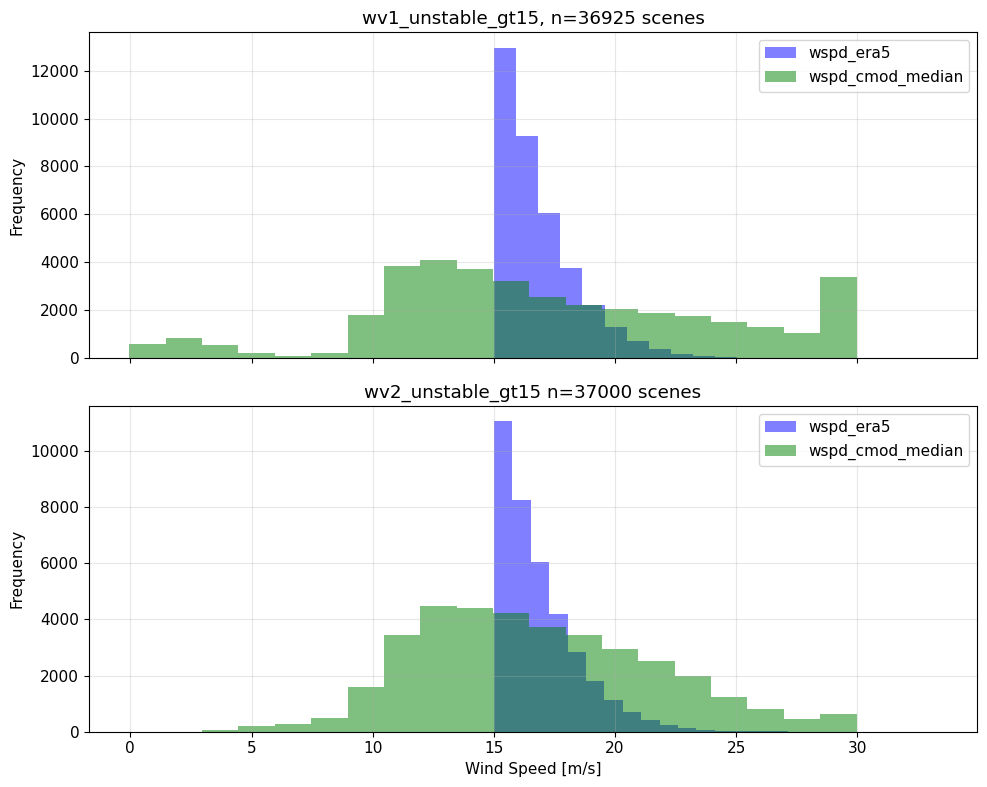

In [163]:
# Create a figure with two subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot first dataset (df_wv1_unstable_gt15) on top subplot
ax1.hist(df_wv1_unstable_gt15["wspd"], bins=20, alpha=0.5, label="wspd_era5", color="blue")
ax1.hist(df_wv1_unstable_gt15["wspd_cmod_median"], bins=20, alpha=0.5, label="wspd_cmod_median", color="green")
ax1.set_title(f"wv1_unstable_gt15, n={len(df_wv1_unstable_gt15)} scenes")
ax1.set_ylabel("Frequency")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot second dataset (df_wv2_unstable_gt15) on bottom subplot
ax2.hist(df_wv2_unstable_gt15["wspd"], bins=20, alpha=0.5, label="wspd_era5", color="blue")
ax2.hist(df_wv2_unstable_gt15["wspd_cmod_median"], bins=20, alpha=0.5, label="wspd_cmod_median", color="green")
ax2.set_title(f"wv2_unstable_gt15 n={len(df_wv2_unstable_gt15)} scenes")
ax2.set_xlabel("Wind Speed [m/s]")
ax2.set_ylabel("Frequency")
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

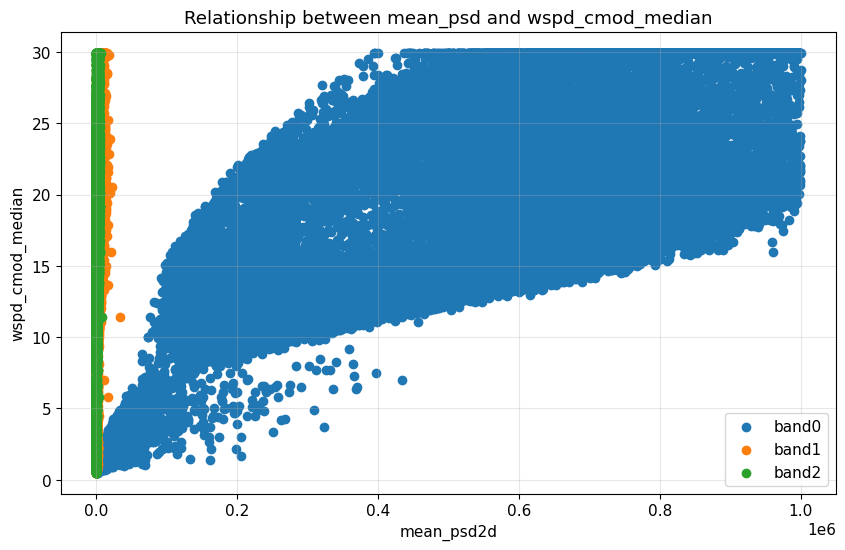

In [185]:
# Filter data where mean_psd2d is smaller than 1e6
filtered_df = df_wv1_unstable_gt15[df_wv1_unstable_gt15["mean_psd_band0"] <1e6]

# Create scatter plot with filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df["mean_psd_band0"], filtered_df["wspd_cmod_median"], label="band0")
plt.scatter(filtered_df["mean_psd_band1"], filtered_df["wspd_cmod_median"], label="band1")
plt.scatter(filtered_df["mean_psd_band2"], filtered_df["wspd_cmod_median"], label="band2")

plt.title("Relationship between mean_psd and wspd_cmod_median")
plt.xlabel("mean_psd2d")
plt.ylabel("wspd_cmod_median")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [173]:
df_wv1_unstable_gt15[["mean_psd2d", "mean_psd_band0"]]

,mean_psd2d,mean_psd_band0
80,13392.163062,408813.083663
82,12255.992273,382311.343180
84,9362.804297,290790.500317
656,27542.209741,800073.912073
658,29415.465102,823632.450842
...,...,...
708304,20555.603573,622803.221768
708308,22620.898850,680433.198332
708310,18368.850148,549564.026841
708314,10456.194415,314791.988010


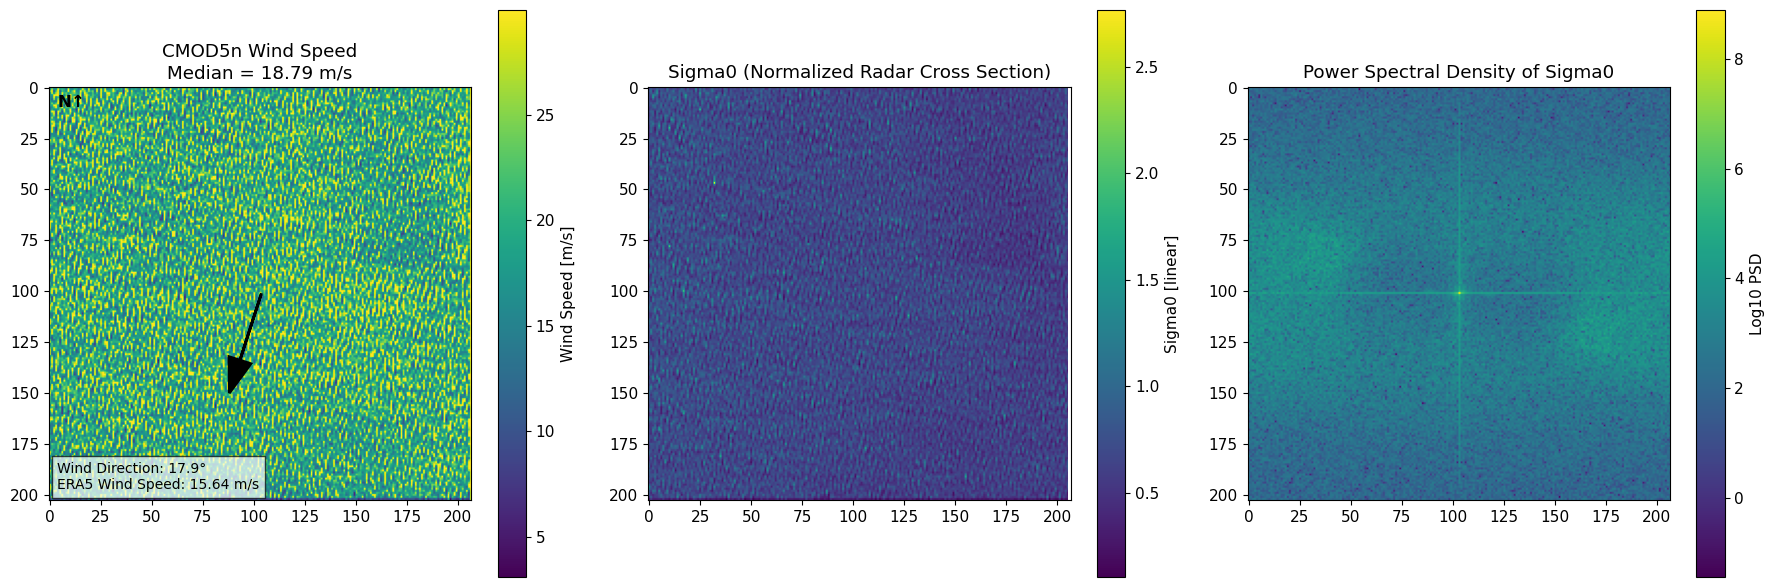

In [113]:
idx = 10
fn = df_wv1_unstable_gt15.renamed_filename.iloc[idx]
wdir_rad = df_wv1_unstable_gt15.wdir.iloc[idx]
wdir_deg = np.rad2deg(wdir_rad)
wdir_deg_from_north = 90 - wdir_deg
wdir_deg_from_north = np.mod(wdir_deg_from_north + 180, 360) - 180

wspd_era5 = df_wv1_unstable_gt15.wspd.iloc[idx]

ds = xr.open_dataset(SAR_data_path / fn)
sigma0 = ds['sigma0'][0]
incidence_angle = ds['incidence'].values
ground_heading = ds['ground_heading'].values

phi = wdir_deg_from_north - ground_heading
phi = np.mod(phi + 180, 360) - 180

# Calculate CMOD wind speed
wspd_cmod = cmod5n_inverse(sigma0, phi, incidence_angle, iterations=10)

# Create 1x3 plot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: CMOD derived wind speed with wind direction arrow
im1 = axes[0].imshow(wspd_cmod)
cbar1 = plt.colorbar(im1, ax=axes[0], label="Wind Speed [m/s]")
axes[0].set_title(f"CMOD5n Wind Speed\nMedian = {np.nanmedian(wspd_cmod):.2f} m/s")


# Get center of the image
center_y, center_x = np.array(wspd_cmod.shape) / 2

arrow_angle_rad = np.deg2rad(wdir_deg_from_north + 180)
dx = np.sin(arrow_angle_rad)  
dy = -np.cos(arrow_angle_rad)  

# Draw arrow
arrow_length = min(wspd_cmod.shape) / 6  
axes[0].arrow(center_x, center_y, dx * arrow_length, dy * arrow_length, 
              head_width=arrow_length/3, head_length=arrow_length/2, 
              fc='k', ec='k', linewidth=2)

# Add North indicator for reference
axes[0].text(0.02, 0.98, "N↑", transform=axes[0].transAxes, 
             fontsize=12, fontweight='bold', va='top')

# Plot 2: Sigma0
im2 = axes[1].imshow(sigma0)
cbar2 = plt.colorbar(im2, ax=axes[1], label="Sigma0 [linear]")
axes[1].set_title("Sigma0 (Normalized Radar Cross Section)")

# Plot 3: PSD of sigma0
# Calculate 2D Power Spectral Density
sigma0_clean = np.nan_to_num(sigma0)  

# First, compute 2D FFT and shift zero frequency to center
f_sigma0 = np.fft.fft2(sigma0_clean)
f_sigma0_shifted = np.fft.fftshift(f_sigma0)
psd_2d = np.abs(f_sigma0_shifted)**2

# Plot PSD (log scale is often better for visualizing PSD)
im3 = axes[2].imshow(np.log10(psd_2d + 1e-10)) 
cbar3 = plt.colorbar(im3, ax=axes[2], label="Log10 PSD")
axes[2].set_title("Power Spectral Density of Sigma0")

# Add annotation for wind direction and ERA5 speed
info_text = f"Wind Direction: {wdir_deg_from_north:.1f}°\nERA5 Wind Speed: {wspd_era5:.2f} m/s"
axes[0].text(0.02, 0.02, info_text, transform=axes[0].transAxes, 
             bbox=dict(facecolor='white', alpha=0.7), fontsize=10, va='bottom')

plt.tight_layout()
plt.show()